In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline

In [ ]:
def f(x):
  # a random xpression
  return 3*x**2 - 4*x + 9

f(10)

269

In [ ]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)

ys

array([104.    ,  95.6875,  87.75  ,  80.1875,  73.    ,  66.1875,
        59.75  ,  53.6875,  48.    ,  42.6875,  37.75  ,  33.1875,
        29.    ,  25.1875,  21.75  ,  18.6875,  16.    ,  13.6875,
        11.75  ,  10.1875,   9.    ,   8.1875,   7.75  ,   7.6875,
         8.    ,   8.6875,   9.75  ,  11.1875,  13.    ,  15.1875,
        17.75  ,  20.6875,  24.    ,  27.6875,  31.75  ,  36.1875,
        41.    ,  46.1875,  51.75  ,  57.6875])

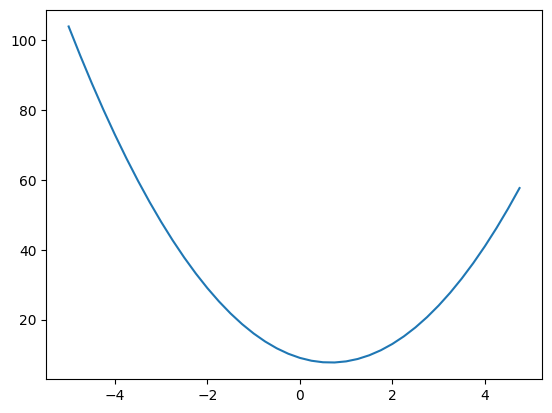

In [ ]:
plt.plot(xs, ys)

In [ ]:
# let 'h' be the small change in input
h = 0.0001
x = 3.0             # notice that at x = 3 has positive slope
(f(x+h) - f(x))/h   # this is the slope

14.000300000063248

In [ ]:
h = 0.0001
x = -3.0     # at x = -2, slope is negative/downward

(f(x+h) - f(x))/h

-21.999700000066014

In [ ]:
h = 0.0001
x = 2/3

(f(x+h) - f(x))/h   # the slope is approx 0 at x = 2/3

0.0002999999981767587

In [ ]:
h = 0.001

# inputs
a = 10.0
b = -2.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1 -->', d1)
print('d2 -->', d2)
print(f'slope --> {(d2-d1)/h:.4f}')


# b is negative, we are bumping 'a' by a small value 'h'.. and a is multiplied with b whihc is -ve
# so when 'a' increases.. result decreases as b

d1 --> -10.0
d2 --> -10.001999999999999
slope --> -2.0000


In [ ]:
class Value:

  def __init__(self, data, _children=(), _op='', label='', grad=0.0):
    self.data = data
    self.label = label
    self.grad = grad
    self._backward = lambda : None
    self._prev = set(_children)   # children nodes
    self._op = _op                # the operation that produced this node

  # to print in a readable format
  def __repr__(self):
    return f"Value(data={self.data}, grad={self.grad})"

  # ---------------- mathematical operations ---------------
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), _op='+')
    def _backward():
      self.grad += 1 * out.grad      # local derivative * gradient
      other.grad += 1 * out.grad     # '+=' as we have to accumulate gradients from all parents..
    out._backward = _backward
    return out

  def __sub__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data - other.data, (self, other), _op='-')
    def _backward():
      self.grad += 1 * out.grad
      other.grad -= 1 * out.grad
    out._backward = _backward
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), _op='*')
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def __truediv__(self, other):
    # a/b = a*(1/b) = a*(b**-1)
    return self * other**-1

  def __radd__(self, other):    # other, self
    return self + other

  def __rsub__(self, other):    # other, self
    return Value(other) - self

  def __rmul__(self, other):    # other, self
    return self * other         # this will call self.__mul__(other)

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self, ), f'**{other}')
    def _backward():
      self.grad += other * (self.data ** (other-1)) * out.grad
    out._backward = _backward
    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    return out

  # --------------- activations ------------------

  def tanh(self):
    x = self.data
    t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
    out = Value(t, (self, ), 'tanh')
    def _backward():
      self.grad += (1-t**2) * out.grad
    out._backward = _backward
    return out

  def relu(self):
    out = Value(0 if self.data < 0 else self.data, (self, ), 'ReLU')
    def _backward():
      self.grad += (out.data > 0) * out.grad
    out._backward = _backward
    return out

  # --------------- backward fxn ----------------
  def backward(self):
    topo = []
    visited = set()

    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [ ]:
a = Value(4.0, label='a')
b = Value(-2.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'    # labels have to be xplicitly defined here
d = e + c; d.label = 'd'
f = Value(2.0, label='f')
L = f * d; L.label = 'L'

print(f"d = {d}")
print(d._prev)
print(d._op)
print(d.label)

d = Value(data=2.0, grad=0.0)
{Value(data=-8.0, grad=0.0), Value(data=10.0, grad=0.0)}
+
d


In [ ]:
# visualization of expression as DAG

from graphviz import Digraph
def trace(root):
  # builds a set of all nodes and edges in the graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child,v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})   # LR --> left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for values in teh graph, let's create a rectangular 'record' node
    dot.node(name = uid, label = "{ %s | data: %.4f | grad: %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this node/value is result of some operation b/w children nodes, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

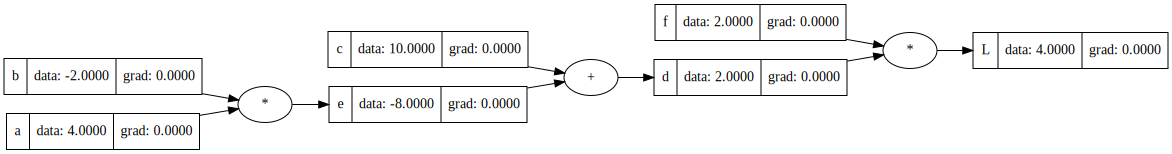

In [ ]:
draw_dot(L)   # notice the forward propogation of value

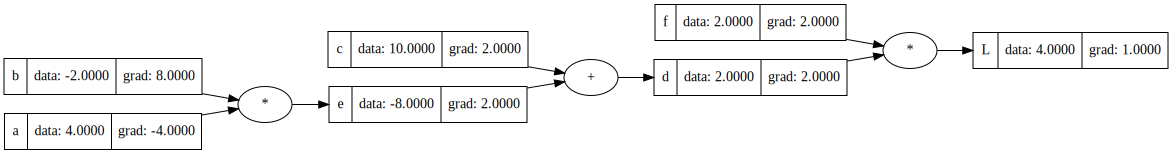

In [ ]:
# calculating individual gradients manually     ...backpropogation
# let h be the small change
h = 0.0001

L.grad = 1.0    # bcoz dL/dL = 1

f.grad = d.data
# dL/df -->
# (g(x+h) - g(x))/h
# ((f + h)*d - f*d)/h
# (f*d + h*d - f*d)/h
# (h*d)/h
# d

# similarly,
d.grad = f.data

# whenever there's a multiplication b/w 2 nodes.. teh 'local' gradient is.. the value of teh other node


c.grad = 1 * d.data
# acc to calculus..
# dL/dc = (dd/dc)*(dL/dd)     # chain rule

# dd/dc = 1 bcoz its an addition operation.. if u increaase c by '1' tehn d increases by '1'
# (f(x+h) - f(x))/h
# ((c+h)+e - (c+e))/h
# (c + h + e - c - e)/h
# h/h = 1
# also by symmetry, dd/de = 1

e.grad = 1 * d.data
# u can say + distributes the grad.. idk?

a.grad = e.grad * b.data
# dL/da = (dL/de) * (de/da) and since its multiplication the value of other node is multiplied as we discussed earlier

b.grad = e.grad * a.data

draw_dot(L)

In [ ]:
# inputs x1 and x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1 and w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of the neuron
b = Value(6.8813735870195432, label='b')      # specific value chosen for calculation convenience in back propogation
#w1x1 + w2x2 + b
w1x1 = w1 * x1; w1x1.label = 'w1x1'
w2x2 = w2 * x2; w2x2.label = 'w2x2'
w1x1w2x2 = w1x1 + w2x2; w1x1w2x2.label = 'w1x1 + w2x2'

n = w1x1w2x2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [ ]:
# base gradient
o.grad = 1

# derivate of tanh is 1-tanh**2
n.grad = (1 - o.data**2) * o.grad

# additive gradients
b.grad = n.grad
w1x1w2x2.grad = n.grad

w2x2.grad = w1x1w2x2.grad
w1x1.grad = w1x1w2x2.grad

# multiplicative gradients
w2.grad = x2.data * w2x2.grad
x2.grad = w2.data * w2x2.grad

x1.grad = w1.data * w1x1.grad
w1.grad = x1.data * w1x1.grad

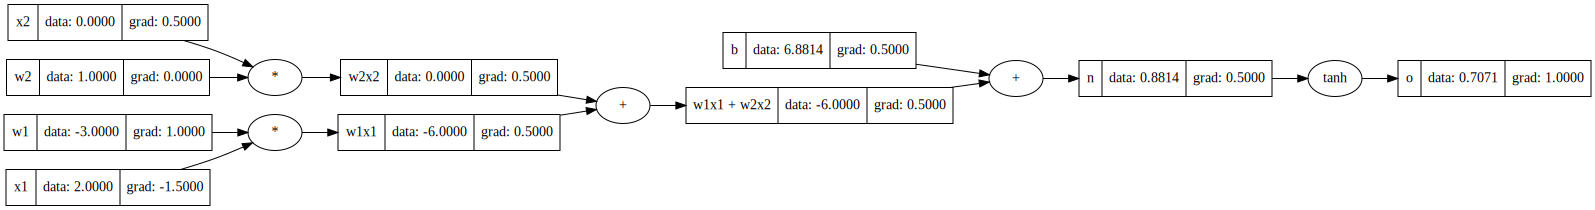

In [ ]:
draw_dot(o)

In [ ]:
# inputs x1 and x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1 and w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of the neuron
b = Value(6.8813735870195432, label='b')      # specific value chosen for calculation convenience in back propogation
#w1x1 + w2x2 + b
w1x1 = w1 * x1; w1x1.label = 'w1x1'
w2x2 = w2 * x2; w2x2.label = 'w2x2'
w1x1w2x2 = w1x1 + w2x2; w1x1w2x2.label = 'w1x1 + w2x2'

n = w1x1w2x2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

# set base grad manually
o.grad = 1.0

In [ ]:
# let's calculate gradient manually
o._backward()

n.grad

0.4999999999999999

In [ ]:
n._backward()

b.grad, w1x1w2x2.grad

(0.4999999999999999, 0.4999999999999999)

In [ ]:
b._backward()   # nothing happens as this is an input node

In [ ]:
w1x1w2x2._backward()

w1x1.grad, w2x2.grad

(0.4999999999999999, 0.4999999999999999)

In [ ]:
w1x1._backward()

w1.grad, x1.grad

(0.9999999999999998, -1.4999999999999996)

In [ ]:
w2x2._backward()

w2.grad, x2.grad

(0.0, 0.4999999999999999)

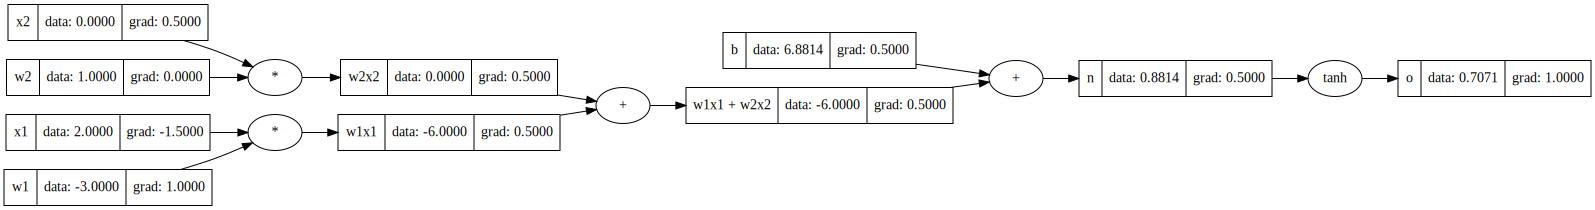

In [ ]:
draw_dot(o)     # identical to manual backpropogation

In [ ]:
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
  return topo

build_topo(o)   # input node - output node

# this ordered list can be used for propogating _backward.. "back propogation"
# but before that it has to be reversed

list(reversed(build_topo(o)))   # output_node - input_node

[Value(data=0.7071067811865476, grad=1.0),
 Value(data=0.8813735870195432, grad=0.4999999999999999),
 Value(data=6.881373587019543, grad=0.4999999999999999),
 Value(data=-6.0, grad=0.4999999999999999),
 Value(data=0.0, grad=0.4999999999999999),
 Value(data=1.0, grad=0.0),
 Value(data=0.0, grad=0.4999999999999999),
 Value(data=-6.0, grad=0.4999999999999999),
 Value(data=2.0, grad=-1.4999999999999996),
 Value(data=-3.0, grad=0.9999999999999998)]

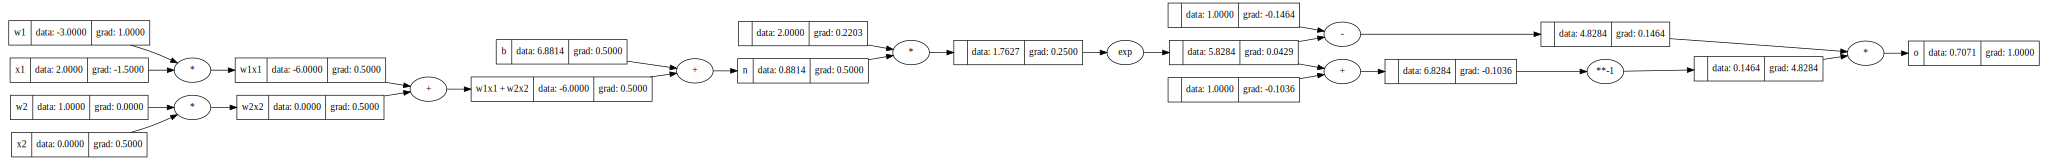

In [ ]:
# using back propogation function..

# inputs x1 and x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1 and w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of the neuron
b = Value(6.8813735870195432, label='b')      # specific value chosen for calculation convenience in back propogation
#w1x1 + w2x2 + b
w1x1 = w1 * x1; w1x1.label = 'w1x1'
w2x2 = w2 * x2; w2x2.label = 'w2x2'
w1x1w2x2 = w1x1 + w2x2; w1x1w2x2.label = 'w1x1 + w2x2'

n = w1x1w2x2 + b; n.label = 'n'

# manually calculating tanh activation
# -----------
e = (2*n).exp()
o = (e-1)/(e+1)
# -----------
o.label = 'o'

o.backward()

draw_dot(o)

In [ ]:
import random

class Model:

  def zero_grad(self):
    for n in self.parameters():
      n.grad = 0.0

  def parameters(self):
    return []

class Neuron(Model):

  def __init__(self, nin, activation='linear'):
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
    self.activation = activation

  def __call__(self, x):
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)    # self.b is used as the start value

    if self.activation == 'relu':
      out = act.relu()
    elif self.activation == 'tanh':
      out = act.tanh()
    else:
      out = act

    return out

  def parameters(self):
    return self.w + [self.b]

  def __repr__(self):
    return f"{self.activation} Neuron({len(self.w)})"

class Layer(Model):                # a list of neurons

  def __init__(self, nin, nout, **kwargs):
    self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

  def __call__(self, x):    # forward pass
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

  def __repr__(self):
    return f"[Layer of {[str(neuron) for neuron in self.neurons]}]"

class MLP(Model):                  # list of layers

  def __init__(self, nin, nouts, activation=None):
    sz = [nin] + nouts      # concat
    if activation is None:
      activation = ['relu']*(len(nouts) - 1) + ['linear']
    self.layers = [Layer(sz[i], sz[i+1], activation=activation[i]) for i in range(len(nouts))]

  def __call__(self, x):    # forward pass
    for layers in self.layers:
      x = layers(x)         # pass x to first layer get output, pass output to second layer get second_output ... pass n-1_output to final layer and get final_output
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

  def __repr__(self):
    return f"MLP of [{',\n '.join(str(layer) for layer in self.layers)}]"

In [ ]:
x = [2.0, 1.0, -1.0]
n = MLP(3, [4, 4, 1])
print(n)

MLP of [[Layer of ['relu Neuron(3)', 'relu Neuron(3)', 'relu Neuron(3)', 'relu Neuron(3)']],
 [Layer of ['relu Neuron(4)', 'relu Neuron(4)', 'relu Neuron(4)', 'relu Neuron(4)']],
 [Layer of ['linear Neuron(4)']]]


In [ ]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

# ys = [1.0, -1.0, -1.0, 1.0]   # targets is using tanh
ys = [1, 0, 0, 1]               # targets if using ReLU

ypred = [n(x) for x in xs]

ypred

[Value(data=1.8096158599735515, grad=0.0),
 Value(data=1.0828200698881774, grad=0.0),
 Value(data=0.2195154335379311, grad=0.0),
 Value(data=1.425980236931122, grad=0.0)]

In [ ]:
[(y - ygt)**2 for y, ygt in zip(ypred, ys)]   # squared error

loss = sum([(y-ygt)**2 for y, ygt in zip(ypred, ys)])   # the loss function

In [ ]:
loss.backward()   # back propogate the loss

# draw_dot(loss)

In [ ]:
print(f"Number of parameters: {len(n.parameters())}")   # we built a neural network of 41 params

Number of parameters: 41


In [ ]:
lr = 0.05
epochs = 100

for epoch in range(epochs):
  ypred = [n(x) for x in xs]
  loss = sum([(yhat - ygt)**2 for yhat, ygt in zip(ypred, ys)])

  for p in n.parameters():
    p.grad = 0.0

  loss.backward()

  for p in n.parameters():
    p.data -= lr * p.grad

  if epoch % 10 == 0:
    print(f"epoch: {epoch} | loss: {loss.data}")

for yhat, ygt in zip(ypred, ys):
  print(f"ground truth: {ygt} | prediction: {yhat.data:.4f}")

epoch: 0 | loss: 2.057623332290591
epoch: 10 | loss: 0.061512065050467364
epoch: 20 | loss: 0.004646887352264543
epoch: 30 | loss: 0.0018401977254608594
epoch: 40 | loss: 0.0009449212564516471
epoch: 50 | loss: 0.0004821790837765503
epoch: 60 | loss: 0.0002425951757252549
epoch: 70 | loss: 0.00012076764598316569
epoch: 80 | loss: 5.966234374388423e-05
epoch: 90 | loss: 2.931456377172532e-05
ground truth: 1 | prediction: 1.0019
ground truth: 0 | prediction: 0.0008
ground truth: 0 | prediction: 0.0008
ground truth: 1 | prediction: 0.9968


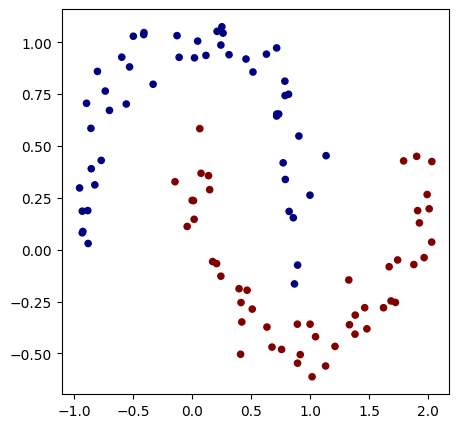

In [ ]:
from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1

plt.figure(figsize=(5,5))
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='jet')

In [ ]:
model = MLP(2, [16, 16, 1], activation=['relu', 'relu', 'linear'])
print(model)
print(f"Number of parameters: {len(model.parameters())}")

MLP of [[Layer of ['relu Neuron(2)', 'relu Neuron(2)', 'relu Neuron(2)', 'relu Neuron(2)', 'relu Neuron(2)', 'relu Neuron(2)', 'relu Neuron(2)', 'relu Neuron(2)', 'relu Neuron(2)', 'relu Neuron(2)', 'relu Neuron(2)', 'relu Neuron(2)', 'relu Neuron(2)', 'relu Neuron(2)', 'relu Neuron(2)', 'relu Neuron(2)']],
 [Layer of ['relu Neuron(16)', 'relu Neuron(16)', 'relu Neuron(16)', 'relu Neuron(16)', 'relu Neuron(16)', 'relu Neuron(16)', 'relu Neuron(16)', 'relu Neuron(16)', 'relu Neuron(16)', 'relu Neuron(16)', 'relu Neuron(16)', 'relu Neuron(16)', 'relu Neuron(16)', 'relu Neuron(16)', 'relu Neuron(16)', 'relu Neuron(16)']],
 [Layer of ['linear Neuron(16)']]]
Number of parameters: 337


In [ ]:
def loss(batch_size=None):

  if batch_size is None:
    Xb, yb = X, y
  else:
    rand_idx = np.random.permutation(X.shape[0])[:batch_size]
    Xb, yb = X[rand_idx], y[rand_idx]
  inputs = [list(map(Value, xrow)) for xrow in Xb]

  scores = list(map(model, inputs))
  # max-margin loss
  losses = [(1 + -y_i*score_i).relu() for y_i, score_i in zip(yb, scores)]
  data_loss = sum(losses) * (1.0/len(losses))
  # L2 regularization
  alpha = 1e-4
  reg_loss = alpha * sum((p*p for p in model.parameters()))
  total_loss = data_loss + reg_loss

  accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
  return total_loss, sum(accuracy)/len(accuracy)

total_loss, acc = loss()
print(total_loss.data, acc)

0.8523831840582055 0.7


In [ ]:
epochs = 100
for k in range(epochs):

  total_loss, acc = loss()

  model.zero_grad()
  total_loss.backward()

  lr = 1.0 - 0.9*k/epochs
  for p in model.parameters():
    p.data -= lr*p.grad

  if k % 10 == 0:
    print(f"epoch: {k} | loss: {total_loss.data} | accuracy: {acc*100}%")

epoch: 0 | loss: 0.8523831840582055 | accuracy: 70.0%
epoch: 10 | loss: 0.41691462624899783 | accuracy: 90.0%
epoch: 20 | loss: 0.2304537402159838 | accuracy: 91.0%


In [ ]:
h = 0.25

xmin, xmax = X[:, 0].min() - 1, X[:, 0].max() + 1
ymin, ymax = X[:, 0].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(xmin, xmax, h),
                     np.arange(ymin, ymax, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list((map(model, inputs)))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlGn, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.jet)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

In [ ]:
# draw_dot(model(x))